In [2]:
'''
Keras image classification that also utilizes Generators. 
A simpler, more introductory model can be found at https://www.kaggle.com/uysimty/get-start-image-classification
'''

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import os

## PARAMETERS ##
print_tensorflow_GPU_info = False
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
random_state = 22
tensorflow_verbosity = "INFO"  # DEBUG(10): All | INFO(20): Info&Warning | WARN(30)[Default]: Warning | ERROR(40): Error | FATAL(50): None
##             ##

## Reproducibility ## 
random.seed(random_state)  # Python's seed
np.random.seed(random_state)  # Numpy's seed
tf.set_random_seed(random_state)  # Tensorflow's seed
##                 ##

Using TensorFlow backend.


In [3]:
## RTX GPU Memory BUG Fix & Must also be placed at the top of the code else it doesn't work ##
from keras.backend import tensorflow_backend as K
tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True                     # dynamically grow the memory used on the GPU
#tf_config.gpu_options.per_process_gpu_memory_fraction = 0.9  # fraction of the GPU to be used
#tf_config.log_device_placement = True                        # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=tf_config)
K.set_session(sess)                     # set this TensorFlow session as the default session for Keras
##  

## Tensorflow Verbosity Module ##
default_verbosity = tf.compat.v1.logging.get_verbosity()
tf.compat.v1.logging.set_verbosity(tensorflow_verbosity)
print(f"\n--CHANGED TENSORFLOW VERBOSITY FROM {default_verbosity/10:.0f} (default) TO {tf.compat.v1.logging.get_verbosity()/10:.0f}")
##                             ##

## Tensorflow GPU Information Module ##
if print_tensorflow_GPU_info == True:
    print(f"\n--AVAILABLE GPUS:")
    K._get_available_gpus()
    print(f"\n--NUM OF GPUs AVAILABLE: {len(tf.config.experimental.list_physical_devices('GPU'))}")
    print(f"\n--IS TF BUILT WITH CUDA: {tf.test.is_built_with_cuda()}")
    print(f"\n--IS GPU AVAILABLE: {tf.test.is_gpu_available()}")
##   


--CHANGED TENSORFLOW VERBOSITY FROM 2 (default) TO 2


## Prepare Traning Data

In [4]:
# Prepare Training Data
filenames = os.listdir("./Datasets/Dogs vs. Cats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [5]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [6]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

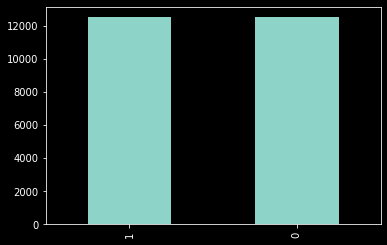

In [7]:
df['category'].value_counts().plot.bar()

## Random sample visualization

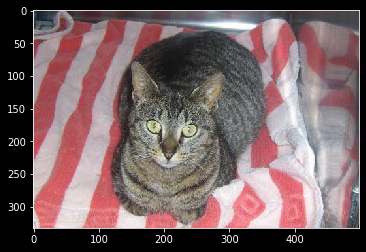

In [8]:
sample = random.choice(filenames)
image = load_img("./Datasets/Dogs vs. Cats/train/"+sample)
plt.imshow(image)

## Validation data preparation

Because we will use image generator `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will map 1 to dog and 0 to cat

In [9]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=random_state)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

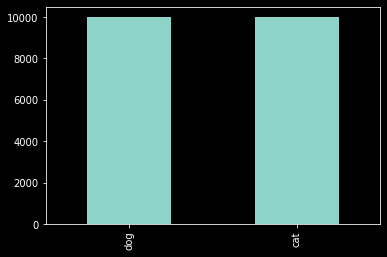

In [10]:
train_df['category'].value_counts().plot.bar()

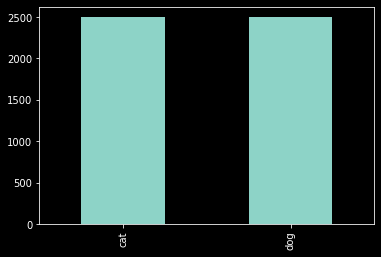

In [11]:
validate_df['category'].value_counts().plot.bar()

In [12]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Model Building

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

In [13]:
# Model Building
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # sigmoid and softmax are both an option

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
______________________________________

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [14]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Data Generators for Training and Validation sets

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./Datasets/Dogs vs. Cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./Datasets/Dogs vs. Cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## Visualization of how the generator works

In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./Datasets/Dogs vs. Cats/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


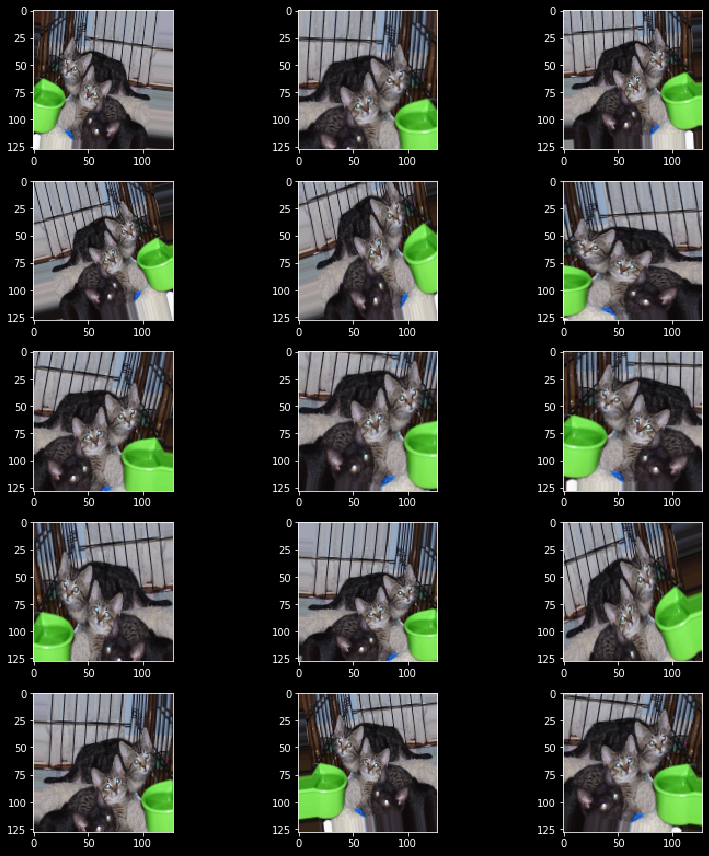

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Model Training

In [19]:
# Model Training
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/3
1333/1333 [==============================] - 90s 67ms/step - loss: 0.7465 - accuracy: 0.6347 - val_loss: 0.7430 - val_accuracy: 0.7111
Epoch 2/3
1333/1333 [==============================] - 89s 67ms/step - loss: 0.5545 - accuracy: 0.7270 - val_loss: 0.4627 - val_accuracy: 0.6154
Epoch 3/3
1333/1333 [==============================] - 89s 66ms/step - loss: 0.5096 - accuracy: 0.7569 - val_loss: 0.8622 - val_accuracy: 0.6947


## Model Analysis

<Figure size 432x288 with 0 Axes>

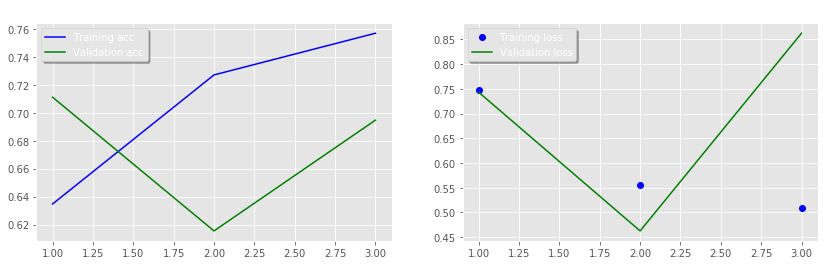

In [20]:
# Model Analysis
def plot_model_history():
    plt.clf()  # clear figure

    plt.style.use('ggplot')

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend(shadow=True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(shadow=True)
    plt.show()
    
plot_model_history()


## Prepare Testing Data

In [21]:
# Prepare Testing Data
test_filenames = os.listdir("./Datasets/Dogs vs. Cats/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Data Generator for Testing Set

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./Datasets/Dogs vs. Cats/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Model Prediction

For categoral classification the prediction will come with a probability for each category. So we will pick the category that have the highest probability with numpy average max

We will convert the predict category back into our generator classes by using `train_generator.class_indices`. It is the classes that image generator map while converting data into computer vision.

In [23]:
# Model Prediction
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our data preparation part. We map data with `{1: 'dog', 0: 'cat'}`. Now we will map the result back to dog is 1 and cat is 0.

In [24]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

## Result Visualization

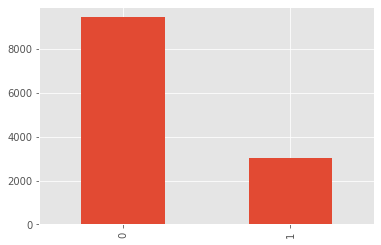

In [25]:
test_df['category'].value_counts().plot.bar()

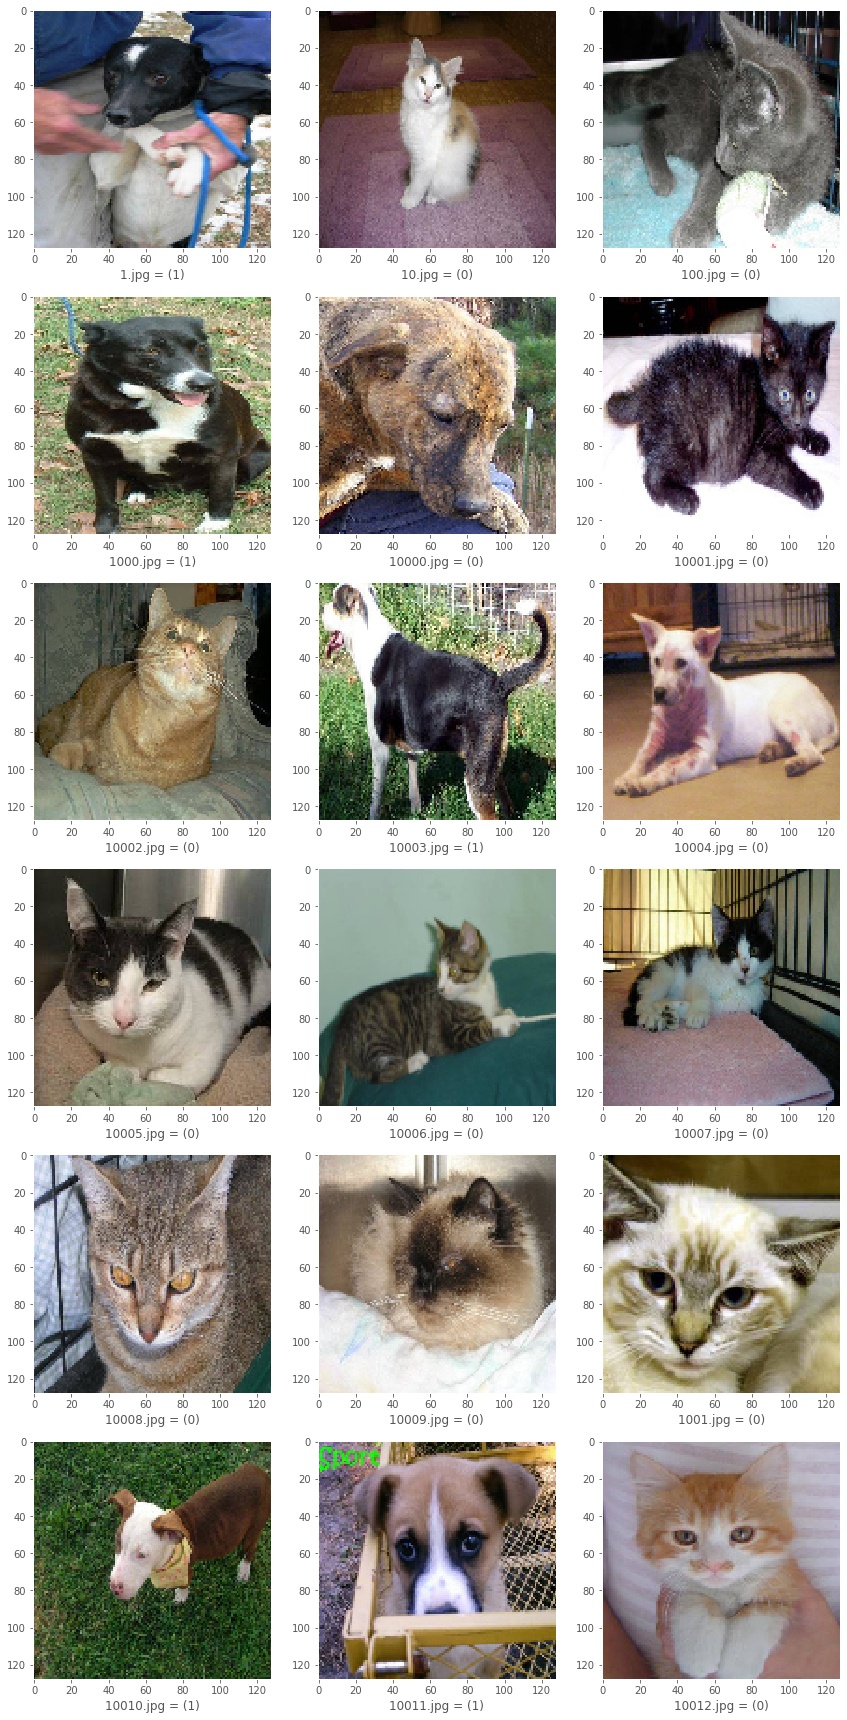

In [37]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./Datasets/Dogs vs. Cats/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.grid(None)
    plt.xlabel(filename + ' = (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()